In [ ]:
# version 0.1.
# author: Lovro Barisic
!pip install mahotas
!pip install --upgrade gdown
import math
import random
from matplotlib import pyplot as plt
import cv2
import mahotas
import skimage
import numpy as np
from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
import copy
from scipy.signal import find_peaks


#download some sample data
!gdown 1j0IU4B_3cfD8H1NxSc2nyJwVq42H9FbF -O pattern01.jpg
!gdown 1mhs1ZG-WhZMKGXwNoHi54kkees0jvAgE -O pattern02.jpg
!gdown 1YnBE2Ji8OrR4RbtKaIVMEQP-LdTGJ07t -O tif01.png
!gdown 16DvNfhoN1YY9AjFF_TlMl6Tw2T2x1DTH -O tif02.tif
#1mhs11234567abcdefg     : ID of a google-drive's shared file (part of "copy-link" option for worldwide shared files)

!ls -la
#to list sample data

Downloading...
From: https://drive.google.com/uc?id=1j0IU4B_3cfD8H1NxSc2nyJwVq42H9FbF
To: /content/pattern01.jpg
100% 484k/484k [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mhs1ZG-WhZMKGXwNoHi54kkees0jvAgE
To: /content/pattern02.jpg
100% 476k/476k [00:00<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YnBE2Ji8OrR4RbtKaIVMEQP-LdTGJ07t
To: /content/tif01.png
100% 4.04M/4.04M [00:00<00:00, 210MB/s]
Downloading...
From: https://drive.google.com/uc?id=16DvNfhoN1YY9AjFF_TlMl6Tw2T2x1DTH
To: /content/tif02.tif
100% 4.56M/4.56M [00:00<00:00, 129MB/s]
total 9368
drwxr-xr-x 1 root root    4096 Mar 11 16:13 .
drwxr-xr-x 1 root root    4096 Mar 11 14:42 ..
drwxr-xr-x 4 root root    4096 Mar  7 14:31 .config
-rw-r--r-- 1 root root  484180 Mar 11 16:13 pattern01.jpg
-rw-r--r-- 1 root root  475557 Mar 11 16:13 pattern02.jpg
drwxr-xr-x 1 root root    4096 Mar  7 14:32 sample_data
-rw-r--r-- 1 root root 4044893 Mar 11 16:13 tif01.png
-rw-r--r-- 1 root 

In [ ]:
#################def
# functions
#################def

def renorm255(img):
  """
  putting max pixel value to 255, min pixel value to 0, everything else lineary distributed
  """
  dummy=[]
  arrM=img.max() # max pixel value of an image
  arrm=img.min() # min pixel value of an image
  for array in img:
    arr_tmp= (array - arrm) / (arrM- arrm) * 255.0
    arr_tmp=arr_tmp.astype(np.uint8)
    dummy.append(arr_tmp)
  renorm_img = np.array(dummy,dtype='uint8')
  return renorm_img

def BlackWhite_split(img):
  """
  Otsu's thresholding Black white split
  """
  otsu_blackwhite_shift=0  #in case we want to make some bias towards white/black
  T_otsu = mahotas.otsu(img) # find Otsu's value (pixel value as threshold for splitting black and white)
  img2=img<T_otsu-otsu_blackwhite_shift #   all pixels of an image will get true/false - splitted BlackWhite
  img3=img2*255  # we want True to be 255 (white)
  img4=np.array(img3,dtype='uint8') # and make it suitable for image operations
  edges = cv2.Canny(img4,0,255) # find edges by Canny algorithm
  bw_edges=edges # these edges are just our first estimate (with simplest algorithm)
  #plotting
  plt.subplot(121),plt.imshow(img,cmap = 'gray')#image22
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(edges,cmap = 'gray')
  plt.title('EdgeBW Image'), plt.xticks([]), plt.yticks([])
  plt.show()
  return (bw_edges,img4)


def piecewise_smoothing(img,bw_edges,number_of_passes):
  """
  piecewise blurring with enhancing edges
  to remove spurious edges
  img: input image to be blurred | image
  bw_edges: first estimate of an edge of img  | image
  number_of_passes | int
  """
  original = img
  #cv2_imshow( original)
  kernel = 7  # blurring parameter
  rangeX = rangeY = 5  # square size of a piece of image that will be blurred
  pix_range = 3   # blurring parameter
  whole_image_blurred = original.copy()
  edge_blurring_parameter=100  # blurr the edge once in a (100) times
  for _ in range(number_of_passes):
    #randomly coose a position on image X,Y
    posX = random.choice(range(img.shape[0]))
    posY = random.choice(range(img.shape[1]))
    rand1 = random.choice(range(edge_blurring_parameter))
    #scheme of the following "if-statement"
    #if (piece not near edge) or (1 in 100 times: i.e. when you're near edge)
    if (255 not in bw_edges[posX-pix_range:posX+pix_range,posY-pix_range:posY+pix_range]) or (rand1 == 1):
      #randomly cooose position/piece on the image to be blurred
      #if edge is nearby blurr it once in 100 times, if it's far from edge blurr it allways
      #that will not distort the edges while it will smooth out the image
      blurred_part = cv2.blur(whole_image_blurred[posX:posX+rangeX, posY:posY+rangeY], ksize=(kernel, kernel) )
      #cv2.blur() function takes only part of the image
      whole_image_blurred[posX:posX+rangeX, posY:posY+rangeY] = blurred_part  #blurr only one part of whole image, leave the rest unchanged

  #plotting
  plt.subplot(121),plt.imshow(original,cmap = 'gray')
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])
  plt.subplot(122),plt.imshow(whole_image_blurred,cmap = 'gray')
  plt.title('piecewisse blurred Image'), plt.xticks([]), plt.yticks([])
  plt.show()
  return whole_image_blurred


(2906, 2890)

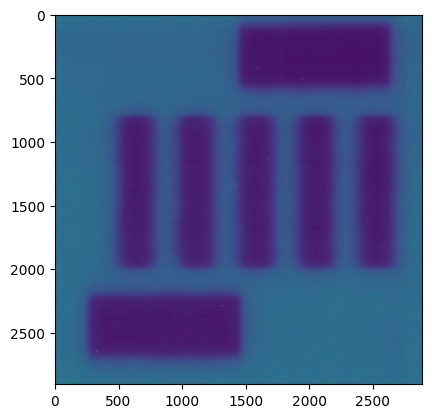

In [ ]:
#read the image from filesystem
input_image = cv2.imread('pattern02.jpg',0);  # 0 flag indicates not to load colors (RGB)
input_image=np.rot90(input_image, k=1, axes=(1,0))  # rotate image if neccessary
#renormalize/rescale pixel values
img255 = renorm255(input_image)

#display image & dimensions
plt.imshow(img255)
input_image.shape

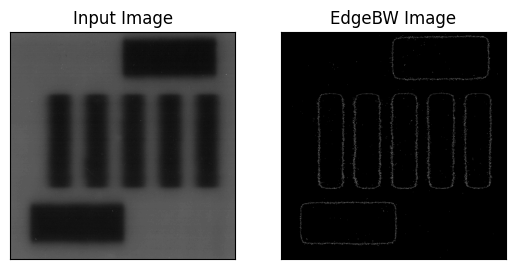

In [ ]:
# make a Black-White split according to Otsu's method, and detect a edge using Canny's algorithm
# this is our first estimate of an edge
(bw_edges,dummy_image) = BlackWhite_split(img255)
#plt.imshow(bw_edges)

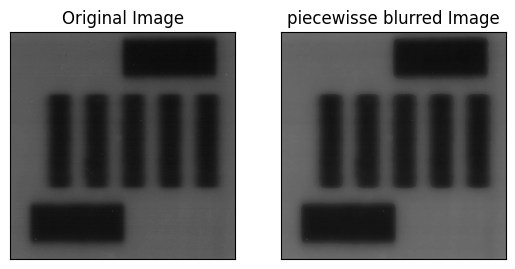

In [ ]:
piecewise_blurred=piecewise_smoothing(img255,bw_edges,(2*100)*100000)   #100 000 passes means ~2 second of calculation time (on average modern computer), around 100-3000| x 100 000 should be used for sufficient smoothing (but it depends on your system/materials used)

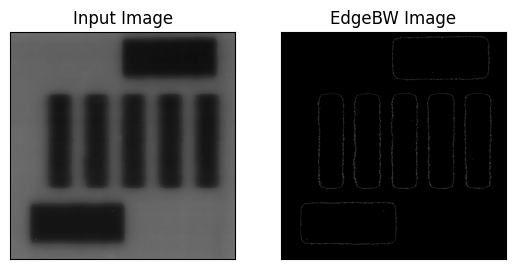

In [ ]:
#our second (better) estimate of an edge
(bw_edges, dummy_blackwhite_image) = BlackWhite_split(piecewise_blurred)

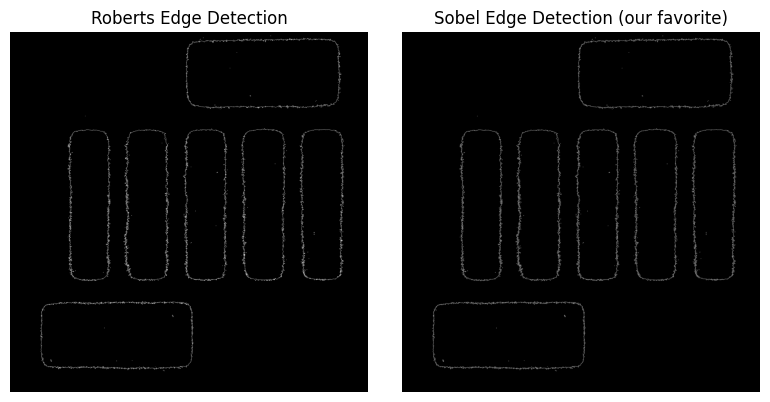

In [ ]:
image = bw_edges
edge_sobel = filters.sobel(image) # we use this one
edge_roberts = filters.roberts(image)  # this would give similar results
#plotting
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(8, 4))
axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')
axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection (our favorite)')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
img = input_image
edged_image = edge_sobel
MLC_arr = []
jaw_arr = []
prominence=0.017
distance=30
# take scanning line in several steps, and readout the coordinates of line-rectangular crossing
for ii in range(0,input_image.shape[0],50):
  print(round(ii/input_image.shape[0]*100,1), '% coordinate scanning completed')
  # take a scanning line on an image (edge-detected)
  x = edged_image[ii]
  peaks2, _ = find_peaks(x, prominence=prominence,distance=distance)      # BEST!
  # even though edge detected image is "smoothed and cleaned", some glitches remain
  # scanning line that passes irradiated rectangular defined by MLC is like a signal with peaks
  # where peak is crossing of a scanning line and an edge

  # take average of neigboring -3 thorug +3 pixels (lower/upper rows):
  # do the same thing 6 more times
  xm3 =edged_image[ii-3]
  peaks2bm3, _ = find_peaks(xm3, prominence=prominence,distance=distance)      #-2
  xm2 =edged_image[ii-2]
  peaks2bm2, _ = find_peaks(xm2, prominence=prominence,distance=distance)      #-3
  xm1 =edged_image[ii-1]
  peaks2bm1, _ = find_peaks(xm1, prominence=prominence,distance=distance)      #-2
  x1 =edged_image[ii+1]
  peaks2b1, _ = find_peaks(x1, prominence=prominence,distance=distance)      #-3
  x2 =edged_image[ii+2]
  peaks2b2, _ = find_peaks(x2, prominence=prominence,distance=distance)      #-2
  x3 =edged_image[ii+3]
  peaks2b3, _ = find_peaks(x3, prominence=prominence,distance=distance)      #-3
  #if number of peaks is not the same on all neigbours: if something went wrong: neglect that scanning line
  if len(peaks2)== len(peaks2bm3)== len(peaks2bm2)== len(peaks2bm1)== len(peaks2b3)== len(peaks2b2)== len(peaks2b1):
    peaksMM=(peaks2+ peaks2bm3+peaks2bm2+peaks2bm1+peaks2b3+peaks2b2+peaks2b1)/7 # mean peak coordiante
    print('Coordianates of detected edges: ', peaksMM)
    print('----------MLC or jaw coordinates found-----')
    if len(peaks2)==10:
      #in our pattern we expect 10 MLC-edges
      MLC_arr.append(peaksMM)
    if len(peaks2)==2:
      #in our pattern we expect 2 Jaw-edges
      jaw_arr.append(peaksMM)


    # draw a scanning line on a image
    # on a original
    photo=copy.deepcopy(input_image) #make a copy of an object, because original would be accessed by reference and change it
    photo=np.ascontiguousarray(photo, dtype=np.uint8)
    cv2.line(photo, pt1=(0,ii), pt2=(photo.shape[0],ii), color=(255,255,255), thickness=5)
    # on a smoothed image
    photo1=copy.deepcopy(piecewise_blurred) #make a copy of an object, because original would be accessed by reference and change it
    photo1=np.ascontiguousarray(photo1, dtype=np.uint8)
    cv2.line(photo1, pt1=(0,ii), pt2=(photo1.shape[0],ii), color=(0,0,255), thickness=5)
    # on a edge-detected image
    photo2=copy.deepcopy(edged_image) #make a copy of an object, because original would be accessed by reference and change it
    photo2=np.ascontiguousarray(renorm255(photo2), dtype=np.uint8)
    cv2.line(photo2, pt1=(0,ii), pt2=(photo2.shape[0],ii), color=(255,255,255), thickness=5)


    #plot the imput image alongside with detected edges
    fig, axes = plt.subplots(ncols=4, sharex=True, sharey=False,
                            figsize=(16, 4))
    axes[0].imshow(photo, cmap=plt.cm.gray)
    axes[0].set_title('position of scanning line: original')
    axes[1].imshow(photo1, cmap=plt.cm.gray)
    axes[1].set_title('position of scanning line: smooth')
    axes[2].imshow(photo2, cmap=plt.cm.gray)
    axes[2].set_title('position of scanning line: edge')
    axes[3].plot(peaks2, x[peaks2], "ob"); plt.plot(x); plt.legend(['detected edges'])
    axes[3].set_title('coordianates of detection')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# print detected coordinates
for ii in MLC_arr:
  #print(ii*25.4/(600))   # inch[mm]/px for a 600 dpi
  pass
for ii in jaw_arr:
  #print(ii*25.4/(600))
  pass

#print width of a rectangular field and watch for irregularities
dpi=25.4/(600) # 1 inch_[milimeter] / 600 pixels
print('width of a rectangular: jaw')
for ii in jaw_arr:
  print(round((ii[0]-ii[1])*25.4/(600),1))
print('width of a rectangular: MLC')
for ii in MLC_arr:
  print(round((ii[0]-ii[1])*dpi,1),round((ii[2]-ii[3])*dpi,1),round((ii[4]-ii[5])*dpi,1),round((ii[6]-ii[7])*dpi,1),round((ii[8]-ii[9])*dpi,2))

width of a rectangular: jaw
-50.2
-51.5
-51.9
-52.1
-52.1
-52.2
-52.4
-52.3
-51.6
-51.0
-51.3
-51.4
-51.7
-51.5
-51.5
-51.2
width of a rectangular: MLC
-12.6 -12.6 -12.5 -13.3 -13.12
-13.5 -13.8 -13.7 -14.3 -14.03
-12.9 -13.6 -13.5 -14.3 -13.66
-12.7 -13.0 -13.3 -13.9 -13.42
-13.5 -13.7 -13.4 -13.9 -13.71
-13.5 -14.1 -13.8 -14.3 -14.04
-13.1 -13.4 -13.6 -14.0 -13.91
-12.9 -13.0 -13.6 -13.6 -14.03
-13.0 -13.5 -13.4 -13.8 -13.43
-13.3 -13.5 -13.0 -13.1 -13.53
-13.2 -13.8 -13.2 -13.4 -13.46
-12.9 -13.0 -13.2 -13.1 -13.55
-13.0 -13.4 -13.1 -13.1 -13.11
-13.2 -13.8 -13.1 -13.1 -13.4
-13.3 -14.6 -13.6 -13.6 -13.26
-13.0 -13.5 -13.1 -13.4 -12.79
-13.0 -13.8 -13.1 -13.3 -12.63
-13.1 -14.2 -13.3 -13.7 -13.48
-12.8 -13.3 -13.4 -13.0 -13.11
-12.2 -12.0 -12.2 -12.1 -12.51


In [ ]:
# this is sufficient to detect anomalies in MLC position
# second step would be to change T_otsu to rescale field size to proper values, etc,etc...